# Training of models

In this notebook, each model explored will be trained and a quick visualization from samples will be shown. Moreover, the location of the input points on the learnt manifold will be represented using the Euclidean chart

## Simple VAE Training

Using device: cpu


100%|██████████| 50/50 [05:04<00:00,  6.10s/it]


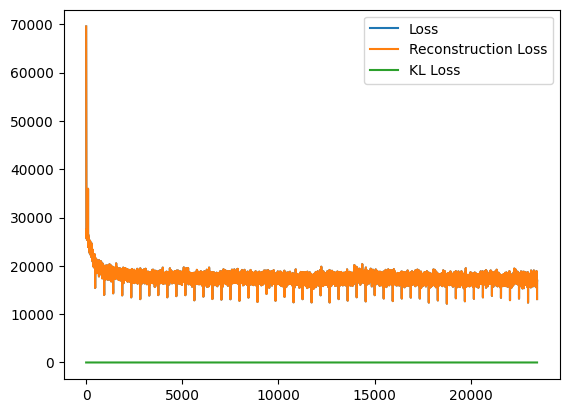

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.vae import VariationalAutoencoder

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 50,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
vae = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)

train_model(vae, trainloader, train_params, device, save=True)

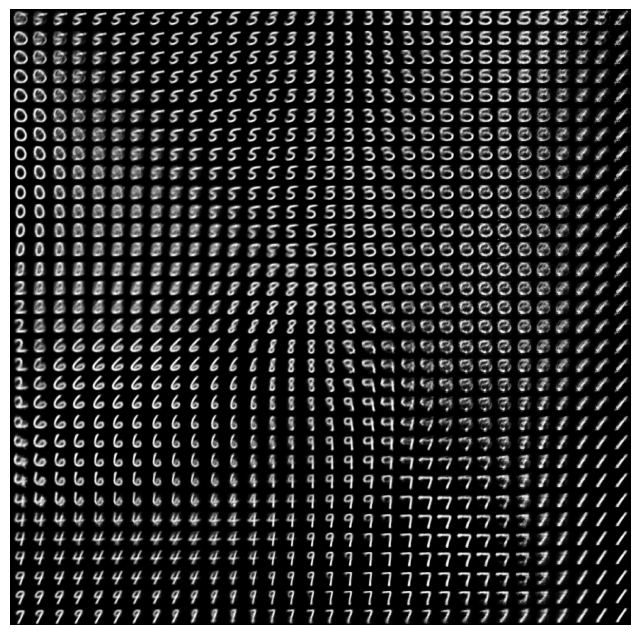

In [2]:
from utils.visualize import visualize_latent_grid

visualize_latent_grid(vae, device, 32)

Some of the bluriness may be explained from a poorly chosen/too-simplistic prior. 

# Isometric Representation

Using device: cpu


100%|██████████| 20/20 [03:26<00:00, 10.33s/it]


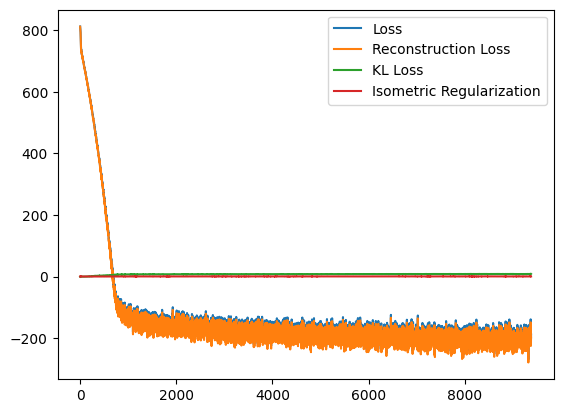

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.training_params import TrainingParameters
from utils.train import train_model
from models.irvae import IRVAE

irvae = IRVAE([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28]).to(device)

train_params = TrainingParameters(
    learning_rate = 1e-3,
    batch_size = 128,
    num_epochs = 20,
)

hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
train_model(irvae, trainloader, train_params, device, save=True)

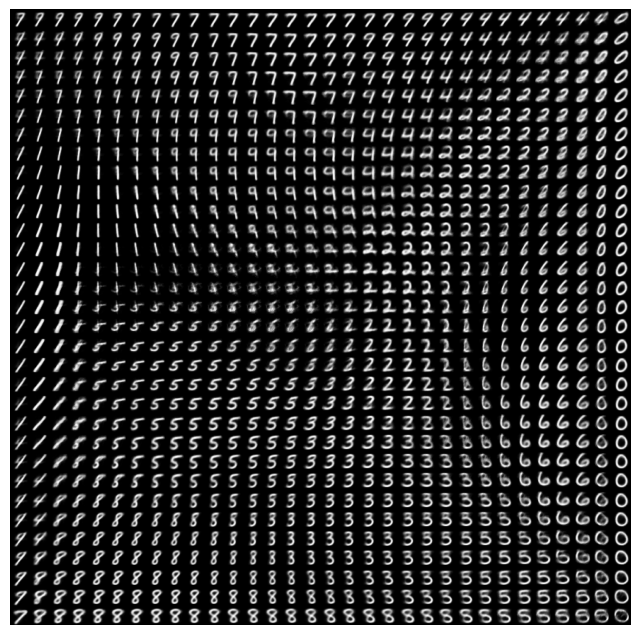

In [4]:
from utils.visualize import visualize_latent_grid

visualize_latent_grid(irvae, device, 32)

## RBF VAE

In [33]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import trange

from utils.training_params import TrainingParameters
from models.vae import VariationalAutoencoder

device = torch.device("cpu")

if not os.path.exists("./pretrained_models/vae.pth"):
    raise KeyError("You need to run the training notebook first.")


hidden_dim = 2
model = VariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load("./pretrained_models/vae.pth", map_location=device, weights_only=True))


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_params = TrainingParameters(
    learning_rate = 1e-3,
    batch_size = 128,
    num_epochs = 300,
)

hidden_dim = 2
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)

In [40]:
z_train = []
y_train = []

model.eval()
with torch.no_grad():
    for x, _ in trainloader:
        _, z, _, _ = model(x)
        
        z_train.append(z.cpu())
        y_train.append(x.cpu())

z_train = torch.cat(z_train, dim=0)
y_train = torch.cat(y_train, dim=0)

z_trainset = torch.utils.data.TensorDataset(z_train, y_train)
z_trainloader = torch.utils.data.DataLoader(z_trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)

In [35]:
from models.rbf import RBFNet
import numpy as np

num_clusters = 64
a = 2

torch.save(z_train, 'pretrained_models/z_train.pt')

rbf = RBFNet(z_train, output_dim=28*28, K=num_clusters, a=a)

100%|██████████| 300/300 [11:39<00:00,  2.33s/it]


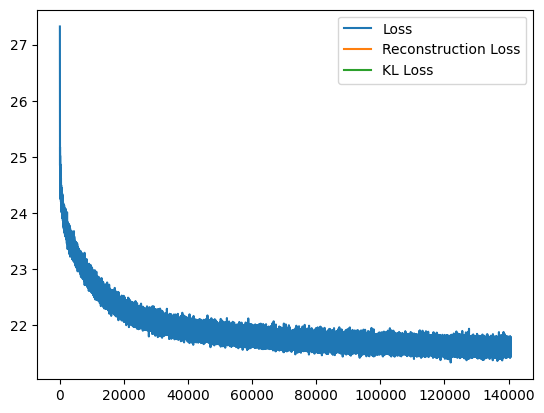

In [36]:
# TODO: Change the code below to train the RBF on encoded x_train dataset:

import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(rbf.parameters(), lr=train_params.learning_rate)
loss_legend = model.loss_legend()
total_losses = [[] for _ in range(len(loss_legend))]

eps = 1e-8
lambda_reg = 1e-4

model.eval()
for epoch in trange(train_params.num_epochs):
    for z, y in z_trainloader:
        z = z.to(device)
        with torch.no_grad():
            y_hat = model.decoder(z).reshape_as(y)
        y_residual = (y-y_hat)**2 + eps
        y_residual = y_residual.clamp_max(1e6)
        # new_y = 1 / y_residual # This is the inverse variance mentioned in the paper.
        new_y = y_residual

        losses = [rbf.loss(z, new_y)]
        total_loss = losses[0]

        # L2 regularization as recommended by the oddity paper
        # TODO: move l2 reg into model?
        l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        total_loss += lambda_reg * l2_norm
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        for i, loss in enumerate(losses):
            total_losses[i].append(loss.item())
        
        # This code should be altered to clamp the W weights to be positive.
        rbf.W.weight.data.clamp_(min=0)


torch.save(rbf.state_dict(), f"./pretrained_models/{rbf.short_name()}.pth")

for loss in total_losses:
    plt.plot(loss)
plt.legend(loss_legend)
plt.show()




Uncertainty stats (mean variance over outputs):
  min:  0.0182
  max:  1000000.0000
  mean: 120007.4375
  std:  308642.6875


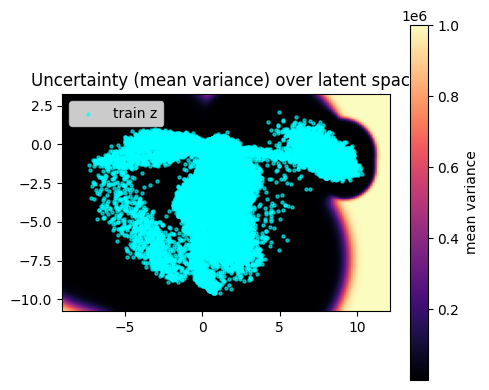

In [48]:
from utils.visualize import visualize_uncertainty
visualize_uncertainty(rbf, z_train, dim0=0, dim1=1, grid_points=150, log_scale=False)

Uncertainty stats (mean variance over outputs):
  min:  0.0182
  max:  1000000.0000
  mean: 120007.4375
  std:  308642.6875


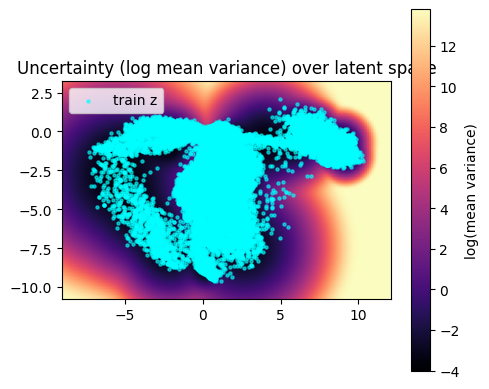

In [ ]:
from utils.visualize import visualize_uncertainty
visualize_uncertainty(rbf, z_train, dim0=0, dim1=1, grid_points=150, log_scale=True)

### Uncertainty-aware VAE
This VAE has two decoder heads, one for the mean and one for the logvar of the generation from latent space to observation space. In doing so, the model explicitly forms a random Riemannian manifold.

This was an attempt at first freezing the variance decoder head and then unfreezing after having trained the mean decoder head.

Using device: cpu


100%|██████████| 30/30 [03:01<00:00,  6.05s/it]


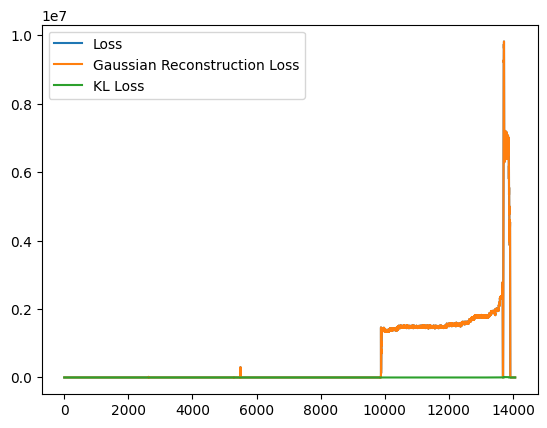

100%|██████████| 30/30 [03:07<00:00,  6.25s/it]


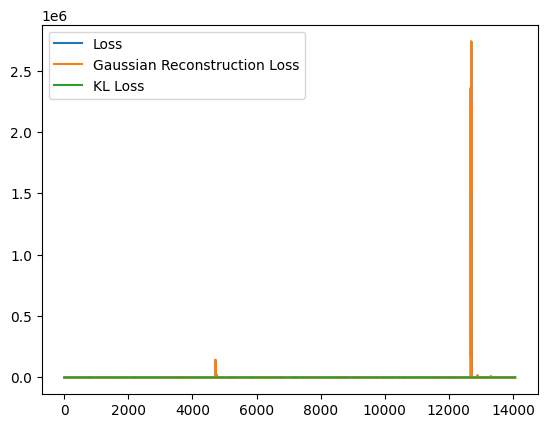

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.vae import GaussianVariationalAutoencoder

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 30,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
uvae = GaussianVariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], hidden_dim=hidden_dim).to(device)

# Train mean decoder head first
uvae.decoder.logvar_head.requires_grad = False
train_model(uvae, trainloader, train_params, device, save=True)

uvae.mu_training = False
uvae.decoder.logvar_head.requires_grad = True
uvae.decoder.mu_head.requires_grad = False
uvae.encoder.requires_grad = False
train_model(uvae, trainloader, train_params, device, save=True)

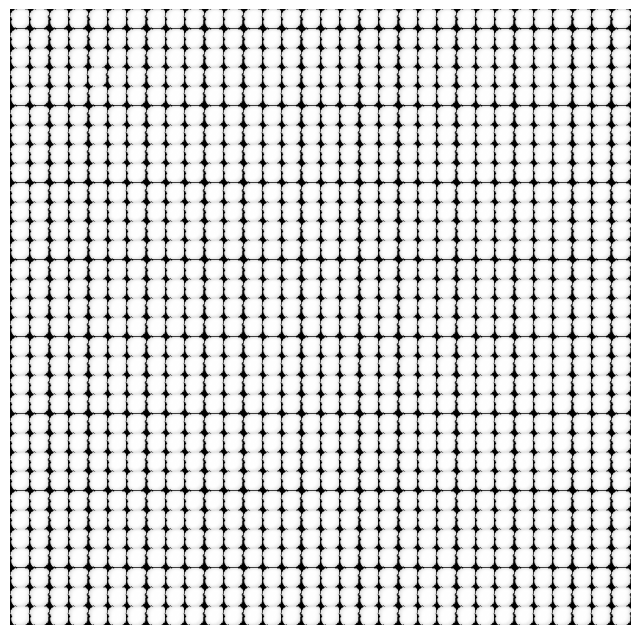

In [12]:
import numpy as np
import matplotlib.pyplot as plt
model = uvae

n_steps = 32

# Create a grid of points between 0.01 and 0.99
x = torch.linspace(0.01, 0.99, n_steps)
y = torch.linspace(0.01, 0.99, n_steps)

# Create a grid of points
grid_points = torch.zeros(n_steps * n_steps, 2)

# Create meshgrid of points
X, Y = torch.meshgrid(x, y, indexing='ij')

# Convert to standard normal values using inverse CDF (probit function)
from scipy.stats import norm
X = torch.tensor(norm.ppf(X.numpy().astype(np.float32)))
Y = torch.tensor(norm.ppf(Y.numpy().astype(np.float32)))

# Combine into grid points
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).float().to(device)

# Generate images from the latent points
with torch.no_grad():
    model.eval()
    # generated = model.mu_decoder(grid_points)
    _, generated = model.decoder(grid_points)
    generated = generated.reshape(-1, 1, 28, 28)

_, axes = plt.subplots(n_steps, n_steps, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_steps):
    for j in range(n_steps):
        axes[i,j].imshow(generated[i * n_steps + j].cpu().squeeze(), cmap='gray')
        axes[i,j].axis('off')

plt.show()

## Uncertainty-aware VAE attempt 2

Using device: cpu


100%|██████████| 50/50 [04:53<00:00,  5.87s/it]


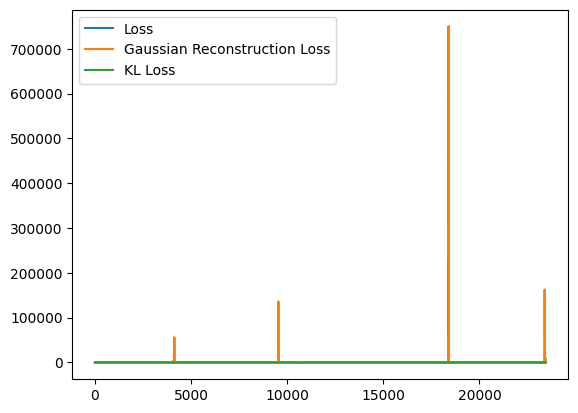

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.vae import GaussianVariationalAutoencoder

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 50,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
uvae = GaussianVariationalAutoencoder([28*28, 400, 200, 50], [50, 100, 200, 400, 28*28], beta=50, hidden_dim=hidden_dim).to(device)

train_model(uvae, trainloader, train_params, device, save=True)

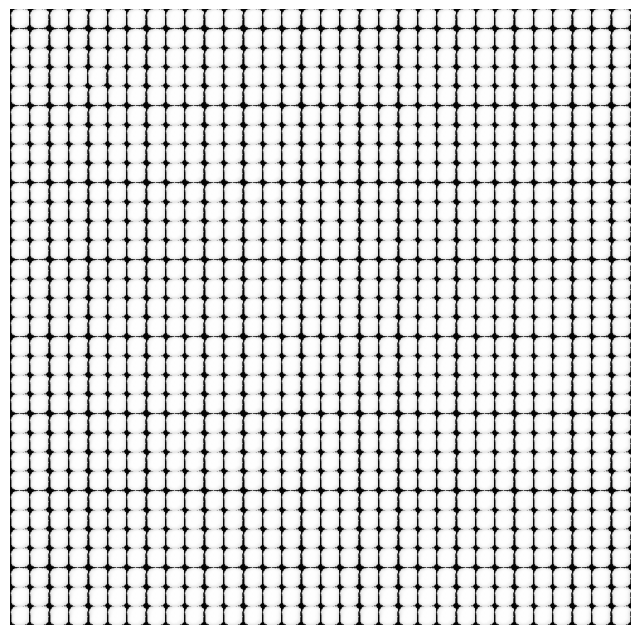

In [7]:
import numpy as np
import matplotlib.pyplot as plt
model = uvae

n_steps = 32


# Create a grid of points between 0.01 and 0.99
x = torch.linspace(0.01, 0.99, n_steps)
y = torch.linspace(0.01, 0.99, n_steps)

# Create a grid of points
grid_points = torch.zeros(n_steps * n_steps, 2)

# Create meshgrid of points
X, Y = torch.meshgrid(x, y, indexing='ij')

# Convert to standard normal values using inverse CDF (probit function)
from scipy.stats import norm
X = torch.tensor(norm.ppf(X.numpy().astype(np.float32)))
Y = torch.tensor(norm.ppf(Y.numpy().astype(np.float32)))

# Combine into grid points
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).float().to(device)

# Generate images from the latent points
with torch.no_grad():
    model.eval()
    (generated, _) = model.decoder(grid_points)
    generated = generated.reshape(-1, 1, 28, 28)

_, axes = plt.subplots(n_steps, n_steps, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_steps):
    for j in range(n_steps):
        axes[i,j].imshow(generated[i * n_steps + j].cpu().squeeze(), cmap='gray')
        axes[i,j].axis('off')

plt.show()


## Simple predictive model

Using device: cpu


100%|██████████| 50/50 [06:06<00:00,  7.32s/it]


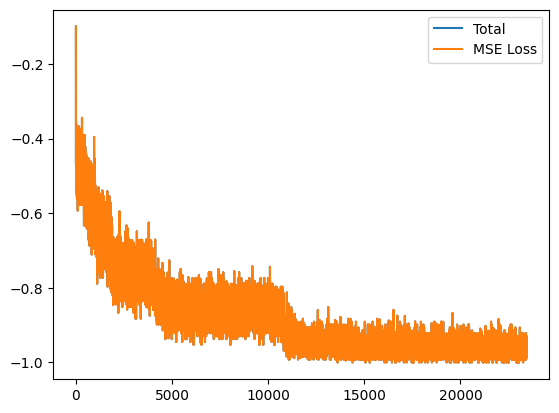

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cpu")

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

from utils.train import train_model
from utils.training_params import TrainingParameters
from models.cnn import CustomCNN

train_params = TrainingParameters(
    learning_rate = 1e-2,
    batch_size = 128,
    num_epochs = 50,
)
hidden_dim = 2

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_params.batch_size, shuffle=True, num_workers=0)
cnn = CustomCNN(1, 10)

train_model(cnn, trainloader, train_params, device, save=True)

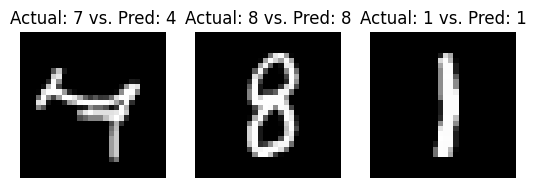

In [21]:
from utils.visualize import visualize_preds

vis_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)
visualize_preds(cnn, vis_loader, torch.device("cpu"), num_samples=3)